In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np
from glob import glob
import matplotlib.pyplot as plt


In [15]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/drive/MyDrive/Colab Notebooks/mask dataset/Train'
valid_path = '/content/drive/MyDrive/Colab Notebooks/mask dataset/Test'


In [16]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
   input_tensor=Input(shape=(224, 224, 3)))

# don't train existing weights
for layer in baseModel.layers:
    layer.trainable = False

In [17]:
  # useful for getting number of output classes
folders = glob('/content/drive/MyDrive/Colab Notebooks/mask dataset/Train/*')
len(folders)

2

In [18]:

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = MaxPooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [19]:

# create a model object
model = Model(inputs=baseModel.input, outputs=headModel)

In [20]:

# view the structure of the model
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [21]:
# tell the model what cost and optimization method to use
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [22]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [23]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/mask dataset/Train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 3131 images belonging to 2 classes.


In [24]:
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/mask dataset/Test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 702 images belonging to 2 classes.


In [25]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
36/98 [==========>...................] - ETA: 5:47 - loss: 0.5562 - accuracy: 0.8524

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


98/98 [==============================] - 771s 8s/step - loss: 0.2978 - accuracy: 0.9138 - val_loss: 0.0870 - val_accuracy: 0.9687
Epoch 2/20
98/98 [==============================] - 42s 431ms/step - loss: 0.0951 - accuracy: 0.9661 - val_loss: 0.0823 - val_accuracy: 0.9672
Epoch 3/20
98/98 [==============================] - 42s 429ms/step - loss: 0.0727 - accuracy: 0.9716 - val_loss: 0.1316 - val_accuracy: 0.9530
Epoch 4/20
98/98 [==============================] - 42s 429ms/step - loss: 0.0692 - accuracy: 0.9738 - val_loss: 0.1079 - val_accuracy: 0.9587
Epoch 5/20
98/98 [==============================] - 42s 429ms/step - loss: 0.0565 - accuracy: 0.9812 - val_loss: 0.0526 - val_accuracy: 0.9815
Epoch 6/20
98/98 [==============================] - 42s 432ms/step - loss: 0.0566 - accuracy: 0.9821 - val_loss: 0.0717 - val_accuracy: 0.9772
Epoch 7/20
98/98 [==============================] - 42s 431ms/step - loss: 0.0545 - accuracy: 0.9824 - val_loss: 0.0647 - val_accuracy: 0.9772
Epoch 8/20
9

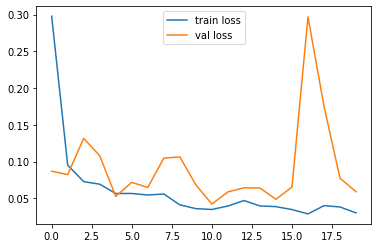

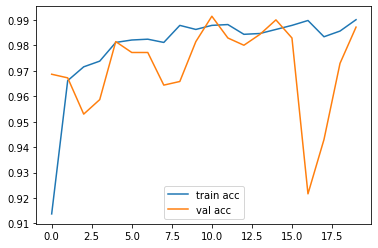

<Figure size 432x288 with 0 Axes>

In [26]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [32]:
model.save("mask.model", save_format="h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [33]:
y_pred = model.predict(test_set)

In [34]:
y_pred

array([[3.3646076e-13, 1.0000000e+00],
       [2.2288243e-10, 1.0000000e+00],
       [2.3211981e-14, 1.0000000e+00],
       ...,
       [1.0000000e+00, 2.7741553e-10],
       [3.5733569e-09, 1.0000000e+00],
       [1.0000000e+00, 2.0959822e-12]], dtype=float32)

In [35]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [36]:
y_pred

array([1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,

In [8]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
model=load_model('mask_detector.model')

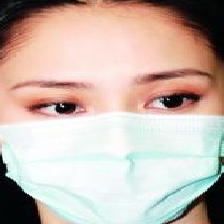

In [51]:
img=image.load_img('C:/Users/KIIT/Desktop/Face-Mask-Detection-master/mask dataset/Test/with_mask/0_0_0 copy 13.jpg',target_size=(224,224))
img

In [52]:
x=image.img_to_array(img)
x.shape
x=x/255.0
reshaped=np.reshape(x,(1,224,224,3))
result=model.predict(reshaped)
label=np.argmax(result,axis=1)[0]
label

0

In [53]:
if label == 0:
    print('With Mask')
else:
    print('Without Mask')

With Mask


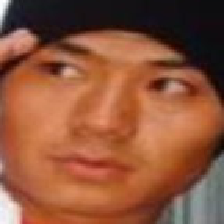

In [54]:
img=image.load_img('C:/Users/KIIT/Desktop/Face-Mask-Detection-master/mask dataset/Test/without_mask/0_0_anhu_0211.jpg',target_size=(224,224))
img

In [55]:
x=image.img_to_array(img)
x.shape
x=x/255.0
reshaped=np.reshape(x,(1,224,224,3))
result=model.predict(reshaped)
label=np.argmax(result,axis=1)[0]
if label == 0:
    print('With Mask')
else:
    print('Without Mask')

Without Mask


## YEAH!! OUR MODEL HAS PREDICTED CORRECTLY